<h5 style="color: orange;">Imports</h5>

These are very basic imports needed for the code to run. `matplotlib` is imported later on as I did graph analysis near the end of the project.

In [1]:
import os
import tensorflow as tf
import json
import pandas as pd
import numpy as np
import random

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

<h5 style="color: orange;"> Ensuring the GPU is used </h5>

As I painfully realized, the CPU is really slow at fitting the models, and the code must meet certain conditions for the GPU to be use-able by `tensorflow`:

 - `tensorflow`'s version must be less than 2.11, as 2.10.1 is the last version that supports GPUs on native windows without any extra installs/workarounds
 - As I have an Nvidia graphics card (2070 Super), the graphics card must meet minimum computing strength as listed on Nvidia's website, and I must have the graphics driver for my card installed
 - `cudatoolkit` and `cudnn` must be installed

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)


Num GPUs Available:  1
2.10.1


<h5 style="color: orange;"> Generating the dataframes </h5>

The data are stored in folders which contain all the files associated with the folder's respective sign. To reduce the size of the data, rows not containing data on the left and right hand are dropped, and the entire `row_id` column is dropped. The `frame` column has its values normalized to ensure the frames start at zero and spaced by just one (instead of two, which would be problematic). To further ensure that the dataframes can be properly processed as features, all `nan` values are replaced with -1.

In [4]:
# Get the directory names of the specific signs to test
tested_signs = ["after", "airplane", "all", "alligator", "animal"]
sign_folders = [f"sorted-signs/{sign_name}/" for sign_name in tested_signs]
type_map = {"face": 1, "pose": 2, "left_hand": 3, "right_hand": 4}

# Load the sign to number map
f = open("sign_to_prediction_index_map.json")
sign_dict = json.load(f)
f.close()

# Generate dataframes using the file data
dataframes = []
for sign_folder in sign_folders:
    file_names = os.listdir(sign_folder)

    for file_name in file_names:
        # Read the file
        df = pd.read_parquet(f"{sign_folder}{file_name}")

        # Drop unnecessary values
        df = df[df["type"] != "face"]
        df = df[df["type"] != "pose"]
        df = df.drop("row_id", axis=1)

        # Encode the signs and types
        df["sign"] = tested_signs.index(sign_folder.split("/")[1])
        df["type"] = df["type"].map(type_map)

        # Normalize the frame numbers and reduce the size by 67%
        df["frame"] = df["frame"] - int(df.iloc[0]["frame"])
        df = df[df["frame"] % 3 == 0]
        df["frame"] /= 3

        # Replace nan with -1 and convert values to float32
        df.fillna(-1, inplace=True)
        df = df.astype({col: 'float32' for col in df.select_dtypes(include=['float64']).columns})
        dataframes.append(df)

    print(f"Files for '{sign_folder}' have been processed.")



Files for 'sorted-signs/after/' have been processed.
Files for 'sorted-signs/airplane/' have been processed.
Files for 'sorted-signs/all/' have been processed.
Files for 'sorted-signs/alligator/' have been processed.
Files for 'sorted-signs/animal/' have been processed.


<h5 style="color: orange;"> Padding the dataframes </h5>
Specifically for this `keras` model, the shapes of the data must be consistent. This being said, the dataframes must thus be padded to ensure each dataframe's `shape` are the same. The number of columns are guarenteed to be constant, so only more rows are necessary. All dataframes have a number of rows that is divisble by 42 because there are 21 rows for the left hand and 21 rows for the right hand. This means that each dataframe must be padded 42 rows at a time to maintain a consistent pattern and size. 

To distinguish padding (frame never existed) and nan values (the -1 values representing that the frame existed but the hand itself did not show up), `-2` will be the value used for `x`, `y`, and `z`.

In [52]:
# left and right hand dataframe pad template
pad_left_df = pd.DataFrame([{"frame": -2, "type": -2, "landmark_index": -2, "x": -2, "y": -2, "z": -2, "sign": -2} for a in range(21)])
pad_right_df = pd.DataFrame([{"frame": -2, "type": -2, "landmark_index": -2, "x": -2, "y": -2, "z": -2, "sign": -2} for a in range(21)])

max_length = max(df.shape[0] for df in dataframes)
print(f"Adjusted (max) length: {max_length}")

for i in range(len(dataframes)):
    # Get relevant data
    df = dataframes[i]
    loops = (max_length - df.shape[0]) // 42
    
    # Pad the dataframes
    for l in range(loops):
        df = pd.concat([df, pad_left_df, pad_right_df], axis=0)

    # Ensure the values are still in float32 after padding
    df = df.astype({col: 'float32' for col in df.select_dtypes(include=['float64']).columns})
    dataframes[i] = df

    print(f"{i}/{len(dataframes)} have been padded.")

Adjusted (max) length: 5796
0/1864 have been padded.
1/1864 have been padded.
2/1864 have been padded.
3/1864 have been padded.
4/1864 have been padded.
5/1864 have been padded.
6/1864 have been padded.
7/1864 have been padded.
8/1864 have been padded.
9/1864 have been padded.
10/1864 have been padded.
11/1864 have been padded.
12/1864 have been padded.
13/1864 have been padded.
14/1864 have been padded.
15/1864 have been padded.
16/1864 have been padded.
17/1864 have been padded.
18/1864 have been padded.
19/1864 have been padded.
20/1864 have been padded.
21/1864 have been padded.
22/1864 have been padded.
23/1864 have been padded.
24/1864 have been padded.
25/1864 have been padded.
26/1864 have been padded.
27/1864 have been padded.
28/1864 have been padded.
29/1864 have been padded.
30/1864 have been padded.
31/1864 have been padded.
32/1864 have been padded.
33/1864 have been padded.
34/1864 have been padded.
35/1864 have been padded.
36/1864 have been padded.
37/1864 have been pa

<h5 style="color: orange;"> Ensuring consistent number of rows </h5>

This chunk of code ensures that the padding was done appropriately as it shows that the minimum number of rows is the same as the maximum number of rows out of all the dataframes.

In [53]:
final_max_length = max(df.shape[0] for df in dataframes)
final_min_length = min(df.shape[0] for df in dataframes)

final_max_length, final_min_length

(5796, 5796)

<h5 style="color: orange;"> Ensuring label normalization </h5>

This chunk of code ensures that the labels are normalized (which is also necessary for the model to one hot encode them) by showing that the labels are integer values from 0 to 6 (there are seven labels at the moment).

In [54]:
a = set([df["sign"].iloc[0] for df in dataframes])

a

{0, 1, 2, 3, 4}

<h5 style="color: orange;"> Feature Extraction </h5>
The `random` module is finally imported to shuffle the dataframes as all the dataframes are grouped by sign. Separating the dataframes into test and train lists will be problematic if this list is not shuffled. The seed is set to 69 due to a lack of creativity and for consistent shuffling.

The dataframes are looped through and converted into 3D tensors with dimensions of number of datapoints, number of rows, and number of features (in this specific order). The labels are extracted and are one hot encoded. The features are then extracted and placed into `data`.

In [55]:
# Shuffle the data
random.Random(69).shuffle(dataframes)

# Convert dataframes to 3D tensor
data = np.zeros((len(dataframes), dataframes[0].shape[0], 6))
labels = np.zeros((len(dataframes), 5))
for i, df in enumerate(dataframes):
    # Extract label
    label = df.iloc[0, -1]
    labels[i] = to_categorical(label, 5)
    
    # Extract features
    features = df.iloc[:, :-1].values
    data[i, :final_max_length, :] = features

<h5 style="color: orange;">Forming the first model</h5>

This is a very simple RNN utilitizing a LSTM layer with 128 neurons, a Dropout layer with a 20% drop off, and a Dense layer for the final layer. `categorical_crossentropy` is used as the loss function as this is a multi-class categorical problem with one-hot encoded labels. The optimizer is `adam` and the metric used is accuracy.

In [56]:
model = Sequential()
model.add(LSTM(128, input_shape=(dataframes[0].shape[0], 6), return_sequences=False))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

<h5 style="color: orange"> Training model v1 </h5>

In [59]:
model_results = model.fit(data, labels, validation_split=0.1, epochs=50, batch_size=32)

Epoch 1/50
53/53 [==============================] - 10s 194ms/step - loss: 1.6051 - accuracy: 0.2188 - val_loss: 1.6046 - val_accuracy: 0.1658
Epoch 2/50
53/53 [==============================] - 10s 191ms/step - loss: 1.6023 - accuracy: 0.2171 - val_loss: 1.6209 - val_accuracy: 0.1979
Epoch 3/50
53/53 [==============================] - 9s 176ms/step - loss: 1.6031 - accuracy: 0.2260 - val_loss: 1.6038 - val_accuracy: 0.1765
Epoch 4/50
53/53 [==============================] - 10s 185ms/step - loss: 1.6016 - accuracy: 0.2123 - val_loss: 1.6172 - val_accuracy: 0.1711
Epoch 5/50
53/53 [==============================] - 10s 183ms/step - loss: 1.6010 - accuracy: 0.2272 - val_loss: 1.5968 - val_accuracy: 0.2620
Epoch 6/50
53/53 [==============================] - 10s 181ms/step - loss: 1.6027 - accuracy: 0.2135 - val_loss: 1.6120 - val_accuracy: 0.2674
Epoch 7/50
53/53 [==============================] - 10s 196ms/step - loss: 1.5994 - accuracy: 0.2260 - val_loss: 1.6066 - val_accuracy: 0.1658


<h5 style="color: orange;">Forming the second model</h5>

In an attempt to improve model v1, a second LSTM layer is added (also with 64 neurons).

In [60]:
model2 = Sequential()
model2.add(LSTM(64, input_shape=(dataframes[0].shape[0], 6), return_sequences=True))
model2.add(LSTM(64, input_shape=(dataframes[0].shape[0], 6), return_sequences=False))
model2.add(Dense(5, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

<h5 style="color: orange"> Training model v2 </h5>

In [61]:
model2_results = model2.fit(data, labels, validation_split=0.1, epochs=50, batch_size=32)

Epoch 1/50
53/53 [==============================] - 21s 332ms/step - loss: 1.6200 - accuracy: 0.2099 - val_loss: 1.6004 - val_accuracy: 0.1979
Epoch 2/50
53/53 [==============================] - 17s 330ms/step - loss: 1.6058 - accuracy: 0.2027 - val_loss: 1.6245 - val_accuracy: 0.1604
Epoch 3/50
53/53 [==============================] - 17s 318ms/step - loss: 1.6094 - accuracy: 0.2111 - val_loss: 1.6176 - val_accuracy: 0.1604
Epoch 4/50
53/53 [==============================] - 17s 322ms/step - loss: 1.5997 - accuracy: 0.2111 - val_loss: 1.6241 - val_accuracy: 0.1711
Epoch 5/50
53/53 [==============================] - 17s 322ms/step - loss: 1.5995 - accuracy: 0.2260 - val_loss: 1.6010 - val_accuracy: 0.2513
Epoch 6/50
53/53 [==============================] - 17s 321ms/step - loss: 1.5997 - accuracy: 0.2075 - val_loss: 1.6086 - val_accuracy: 0.2567
Epoch 7/50
53/53 [==============================] - 17s 313ms/step - loss: 1.6028 - accuracy: 0.2153 - val_loss: 1.6031 - val_accuracy: 0.1979

<h5 style="color: orange;">Forming the third model</h5>

In an attempt to improve model v2, a third LSTM layer is added (now with only 32 neurons).

In [62]:
model3 = Sequential()
model3.add(LSTM(64, return_sequences=True, input_shape=(dataframes[0].shape[0], 6)))
model3.add(LSTM(64, return_sequences=True))
model3.add(LSTM(32, return_sequences=False))
model3.add(Dense(5, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

<h5 style="color: orange"> Training model v3 </h5>

In [63]:
model3_results = model3.fit(data, labels, validation_split=0.1, epochs=50, batch_size=32)

Epoch 1/50
53/53 [==============================] - 29s 469ms/step - loss: 1.6227 - accuracy: 0.1962 - val_loss: 1.6139 - val_accuracy: 0.2139
Epoch 2/50
53/53 [==============================] - 24s 446ms/step - loss: 1.6134 - accuracy: 0.2081 - val_loss: 1.6130 - val_accuracy: 0.2086
Epoch 3/50
53/53 [==============================] - 24s 454ms/step - loss: 1.6068 - accuracy: 0.2093 - val_loss: 1.6154 - val_accuracy: 0.1658
Epoch 4/50
53/53 [==============================] - 25s 465ms/step - loss: 1.6048 - accuracy: 0.2147 - val_loss: 1.6079 - val_accuracy: 0.2032
Epoch 5/50
53/53 [==============================] - 24s 458ms/step - loss: 1.6012 - accuracy: 0.2099 - val_loss: 1.6168 - val_accuracy: 0.1604
Epoch 6/50
53/53 [==============================] - 23s 443ms/step - loss: 1.6009 - accuracy: 0.2326 - val_loss: 1.6072 - val_accuracy: 0.1497
Epoch 7/50
53/53 [==============================] - 23s 442ms/step - loss: 1.6039 - accuracy: 0.2159 - val_loss: 1.6017 - val_accuracy: 0.2032

<h5 style="color: orange;">Forming the fourth model</h5>

In a second attempt to improve model v2, the layers are kept the same, but the `rmsprop` optimizer function is used instead. There's no real basis for this usage other than curiosity as I ran into this optimizer while reading about `adam`.

In [64]:
model4 = Sequential()
model4.add(LSTM(64, input_shape=(dataframes[0].shape[0], 6), return_sequences=True))
model4.add(LSTM(64, input_shape=(dataframes[0].shape[0], 6), return_sequences=False))
model4.add(Dense(5, activation='softmax'))
model4.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

<h5 style="color: orange"> Training model v4 </h5>

In [65]:
model4_results = model4.fit(data, labels, validation_split=0.1, epochs=50, batch_size=32)

Epoch 1/50
53/53 [==============================] - 20s 321ms/step - loss: 1.6253 - accuracy: 0.2033 - val_loss: 1.6188 - val_accuracy: 0.2032
Epoch 2/50
53/53 [==============================] - 16s 300ms/step - loss: 1.6137 - accuracy: 0.2004 - val_loss: 1.6002 - val_accuracy: 0.1979
Epoch 3/50
53/53 [==============================] - 16s 308ms/step - loss: 1.6096 - accuracy: 0.2063 - val_loss: 1.6005 - val_accuracy: 0.2406
Epoch 4/50
53/53 [==============================] - 17s 314ms/step - loss: 1.6068 - accuracy: 0.2105 - val_loss: 1.6087 - val_accuracy: 0.1979
Epoch 5/50
53/53 [==============================] - 17s 318ms/step - loss: 1.6042 - accuracy: 0.2075 - val_loss: 1.5974 - val_accuracy: 0.1765
Epoch 6/50
53/53 [==============================] - 17s 317ms/step - loss: 1.5986 - accuracy: 0.2433 - val_loss: 1.6079 - val_accuracy: 0.2406
Epoch 7/50
53/53 [==============================] - 17s 318ms/step - loss: 1.6012 - accuracy: 0.2075 - val_loss: 1.5972 - val_accuracy: 0.2406

<h5 style="color: orange;">Forming the fifth model</h5>

This time, I tried using a `Masking` layer so the model can ignore the padding and focus on just the relevant timeframes. The masking value is set to -2 as the padding has values all set to -2.

In [66]:
from tensorflow.keras.layers import Masking

model5 = Sequential()
model5.add(Masking(mask_value=-2, input_shape=(dataframes[0].shape[0], 6)))
model5.add(LSTM(64, return_sequences=True))
model5.add(LSTM(64, return_sequences=False))
model5.add(Dense(5, activation='softmax'))
model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

<h5 style="color: orange"> Training model v5 </h5>

In [67]:
model5_results = model5.fit(data, labels, validation_split=0.1, epochs=50, batch_size=32)

Epoch 1/50
53/53 [==============================] - 28s 372ms/step - loss: 1.6261 - accuracy: 0.1986 - val_loss: 1.6002 - val_accuracy: 0.1925
Epoch 2/50
53/53 [==============================] - 17s 320ms/step - loss: 1.6074 - accuracy: 0.2284 - val_loss: 1.5960 - val_accuracy: 0.2513
Epoch 3/50
53/53 [==============================] - 17s 321ms/step - loss: 1.6052 - accuracy: 0.2051 - val_loss: 1.6186 - val_accuracy: 0.1979
Epoch 4/50
53/53 [==============================] - 17s 323ms/step - loss: 1.6016 - accuracy: 0.2212 - val_loss: 1.6029 - val_accuracy: 0.2460
Epoch 5/50
53/53 [==============================] - 17s 323ms/step - loss: 1.6047 - accuracy: 0.2093 - val_loss: 1.6191 - val_accuracy: 0.1979
Epoch 6/50
53/53 [==============================] - 17s 322ms/step - loss: 1.6011 - accuracy: 0.2206 - val_loss: 1.6029 - val_accuracy: 0.2620
Epoch 7/50
53/53 [==============================] - 17s 322ms/step - loss: 1.5994 - accuracy: 0.2165 - val_loss: 1.6133 - val_accuracy: 0.1925

<h5 style="color: orange;">Forming the sixth model</h5>

In an attempt to improve the fifth model, the first LSTM layer now has 128 neurons (from 64 neurons).

In [68]:
model6 = Sequential()
model6.add(Masking(mask_value=-2, input_shape=(dataframes[0].shape[0], 6)))
model6.add(LSTM(128, return_sequences=True))
model6.add(LSTM(64, return_sequences=False))
model6.add(Dense(5, activation='softmax'))
model6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

<h5 style="color: orange"> Training model v6 </h5>

In [69]:
model6_results = model6.fit(data, labels, validation_split=0.1, epochs=50, batch_size=32)

Epoch 1/50
53/53 [==============================] - 28s 392ms/step - loss: 1.6256 - accuracy: 0.2075 - val_loss: 1.6215 - val_accuracy: 0.2620
Epoch 2/50
53/53 [==============================] - 19s 350ms/step - loss: 1.6085 - accuracy: 0.2171 - val_loss: 1.6143 - val_accuracy: 0.1658
Epoch 3/50
53/53 [==============================] - 19s 351ms/step - loss: 1.6050 - accuracy: 0.2248 - val_loss: 1.6045 - val_accuracy: 0.2620
Epoch 4/50
53/53 [==============================] - 18s 348ms/step - loss: 1.6085 - accuracy: 0.2033 - val_loss: 1.6032 - val_accuracy: 0.2513
Epoch 5/50
53/53 [==============================] - 18s 344ms/step - loss: 1.5982 - accuracy: 0.2284 - val_loss: 1.5982 - val_accuracy: 0.2781
Epoch 6/50
53/53 [==============================] - 18s 346ms/step - loss: 1.5980 - accuracy: 0.2135 - val_loss: 1.6110 - val_accuracy: 0.1711
Epoch 7/50
53/53 [==============================] - 18s 347ms/step - loss: 1.5996 - accuracy: 0.2355 - val_loss: 1.5947 - val_accuracy: 0.2299

<h5 style="color: orange;"> Creating plots for the model histories </h5>

Below is a simple function that takes the history from a model's results and plots the training and validation versions of whatever statistic is given (which is either `accuracy` or `loss`).

In [70]:
from matplotlib import pyplot as plt

def plot_stat(history, name: str, stat: str) -> None:
    """ Plots the stat, as seen in the model history, as a function of the epoch number """
    # Title
    plt.title(f"{stat.capitalize()} of model: {name}")

    # Plotting
    plt.plot(history[stat])
    plt.plot(history[f"val_{stat}"])

    # Labelling the axes + making legends
    plt.xlabel("Epoch")
    plt.ylabel(f"{stat.capitalize()}")
    plt.legend(["train", "val"], loc="upper left")

    # Setting the x and y ticks
    plt.xticks(np.arange(0, 55, 5))
    
    low = min(min(history[stat]), min(history[f"val_{stat}"]))
    high = max(max(history[stat]), max(history[f"val_{stat}"]))
    step = (high - low) / 10
    plt.yticks(np.arange(low, high + step, step))
    
    # Set horizontal line at random chance accuracy
    if stat == "accuracy":
        plt.axhline(y=0.2, color="r", linestyle="-")

    # Reveal the graph
    plt.show()
    

<h5 style="color: orange;"> Plotting the statistics </h5>

Here, you will see the training + validation accuracy graphs and the training + validation accuracy graphs for each model. The order of the graphs starts from the first model and does the accuracy and loss graphs and then goes onto the next model and outputs the respective graphs once again until all the models have been analyzed. The models need to perform better than random chance (20%) for them to be useful at all, so red horizontal lines at y = 0.2 is drawn on all the accuracy graphs to better visualize the models' efficacy.

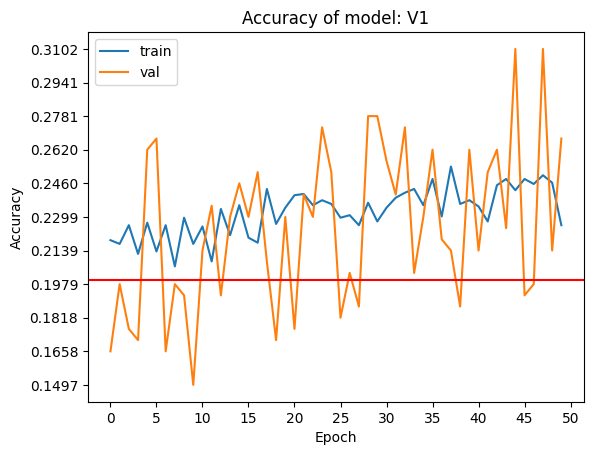

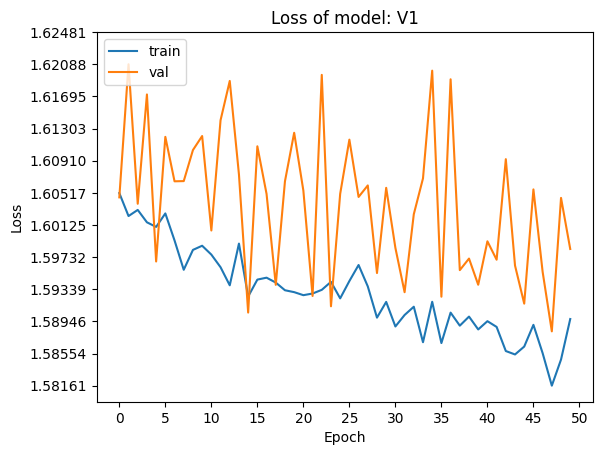

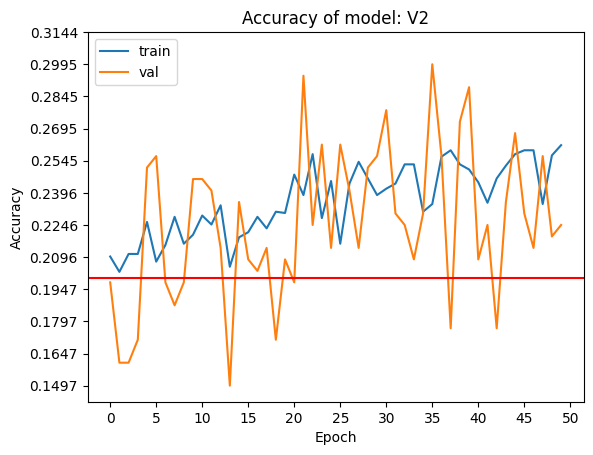

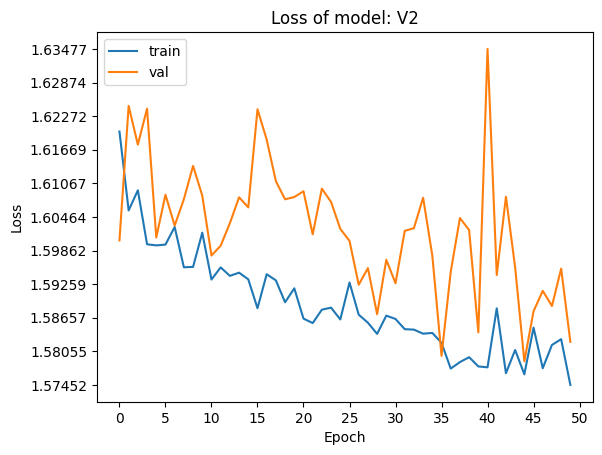

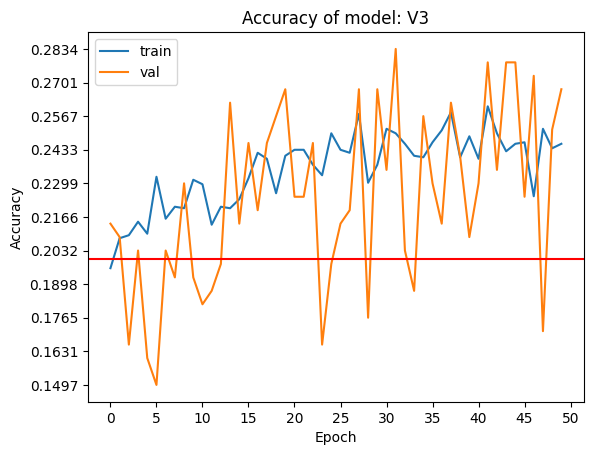

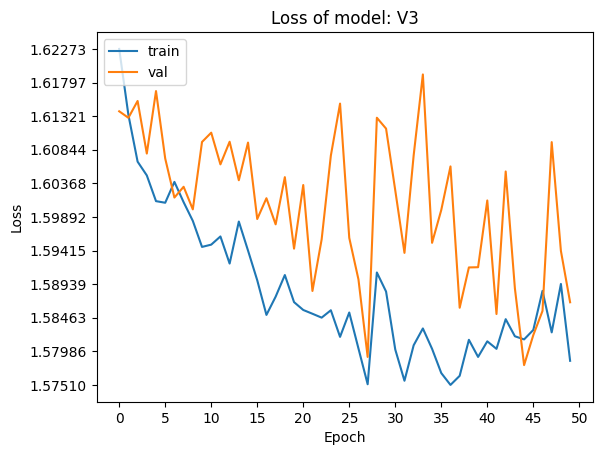

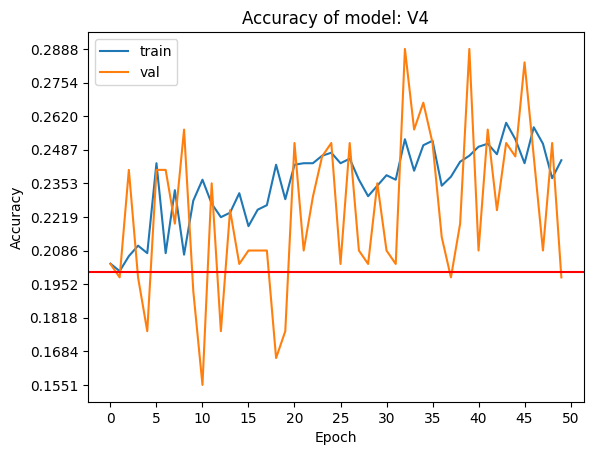

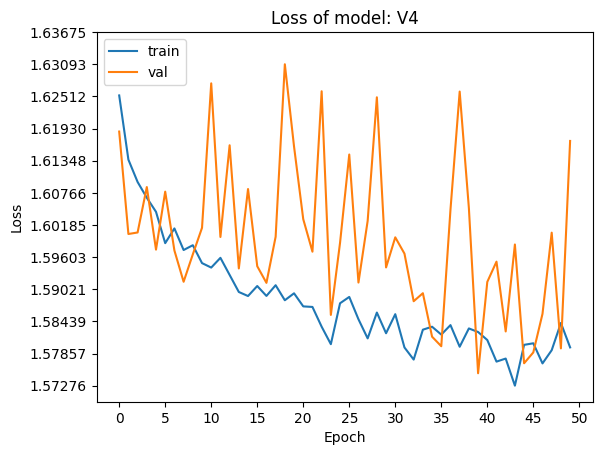

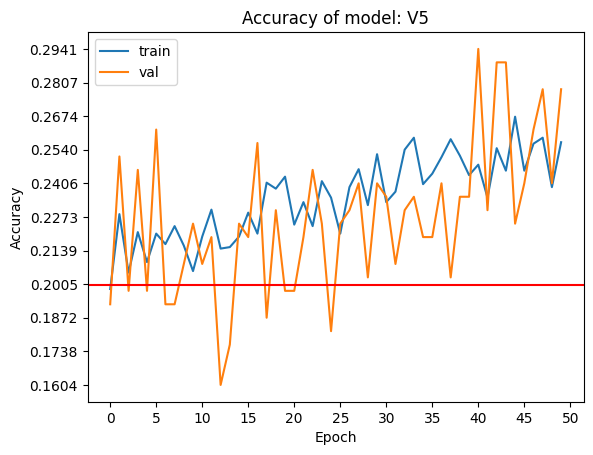

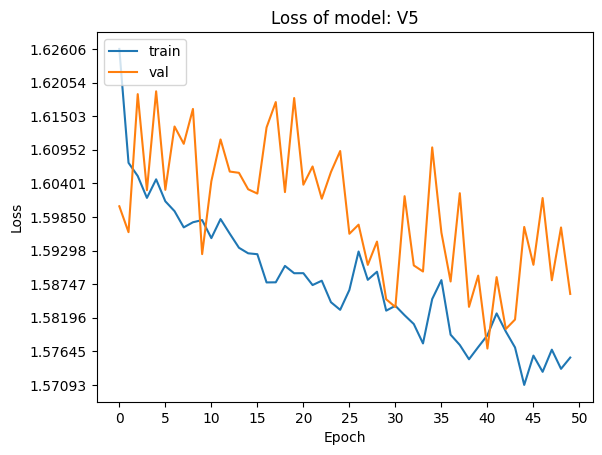

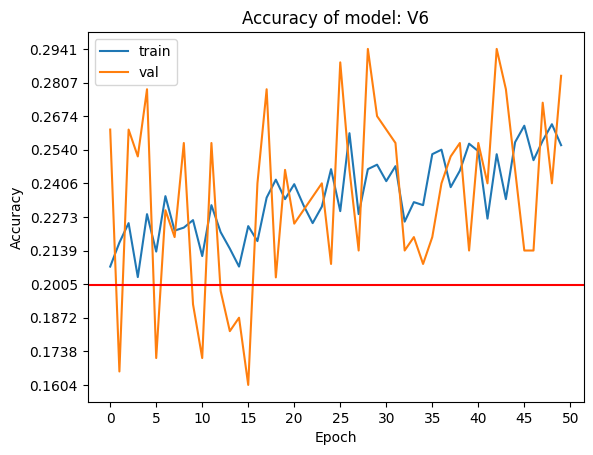

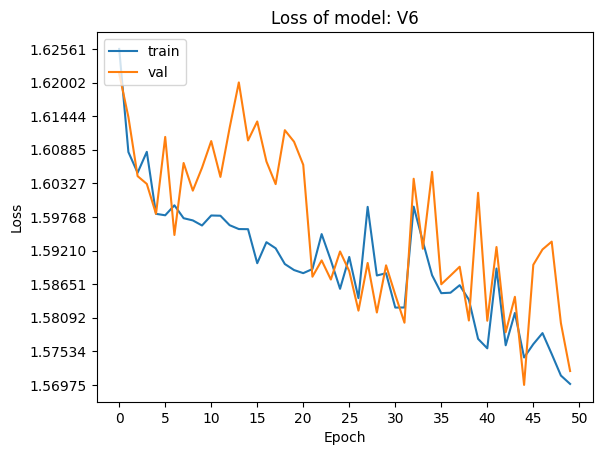

In [71]:
histories = {"V1": model_results.history, "V2": model2_results.history,
             "V3": model3_results.history, "V4": model4_results.history,
             "V5": model5_results.history, "V6": model6_results.history}

for model_version in histories:
    plot_stat(histories[model_version], model_version, "accuracy")
    plot_stat(histories[model_version], model_version, "loss")

<h5 style="color: orange;"> More analysis of the graphs </h5>

A more numeric approach will be used to analyze the models. The following data will be collected and displayed in four tables (one table each for the two accuracies (training and validation sets) and one table  each for the two losses (training and validation sets)):

 - Model name
 - Start and end accuracy
 - Minimum, maximum, and average accuracy
 - Standard deviation of the accuracy
 - Start and end loss
 - Minimum, maximum, and average loss
 - Standard deviation of the loss

 Four more tables are created to rank the models as either highest or lowest in the respective categories (one table each for the two accuracies (training and validation sets) and one table  each for the two losses (training and validation sets)).

In [100]:
# Function for generating the data table
def generate_info_df(models, stat: str, is_training: bool) -> list[pd.DataFrame]:
    """ Generate a Pandas DataFrame to store numeric information about a specific statistic in regards to a specific model history.
        Also generates a Pandas DataFrame to rank the models."""

    # Dict of data to hold the models' statistics
    information = {"Model Name": [], "Start": [], "End": [],
                   "Min": [], "Max": [], "Avg": [], "Stdev": []}
    
    # Obtain information of all the models
    for model_version in models:
        # Add the name
        information["Model Name"].append(model_version)

        # Extract the information of the model into the dictionary
        stat_label = '' if is_training else 'val_'
        full_stat = f"{stat_label}{stat}"

        accuracies = list(histories[model_version][full_stat])
        information["Start"].append(accuracies[0])
        information["End"].append(accuracies[-1])
        information["Min"].append(min(accuracies))
        information["Max"].append(max(accuracies))
        information["Avg"].append(f"{sum(accuracies) / len(accuracies) : .4f}")
        information["Stdev"].append(np.std(accuracies))

    # Create the stats dataframe
    stats_df = pd.DataFrame(information)

    # Dict of data to hold the highest and lowest ranking models
    ranks = {"": ["Highest", "Lowest"], "Start": [], "End": [], 
             "Min": [], "Max": [], "Avg": [], "Stdev": []}
    
    # Populate the ranks dict
    for stat in ranks.keys():
        # Skips the first placeholder column
        if stat in information.keys():
            # Extract the model names
            model_stats = information[stat]
            highest_model = f"V{model_stats.index(max(model_stats)) + 1}"
            lowest_model = f"V{model_stats.index(min(model_stats)) + 1}"

            ranks[stat].append(highest_model)
            ranks[stat].append(lowest_model)

    # Create the ranks dataframe
    ranks_df = pd.DataFrame(ranks)

    # Return the values
    return stats_df, ranks_df


# Generating the tables
stat_train_acc, rank_train_acc = generate_info_df(histories, "accuracy", True)
stat_val_acc, rank_val_acc = generate_info_df(histories, "accuracy", False)
stat_train_loss, rank_train_loss = generate_info_df(histories, "loss", True)
stat_val_loss, rank_val_loss = generate_info_df(histories, "loss", False)


In [101]:
print("Accuracy statistics (training dataset)")
stat_train_acc


Accuracy statistics (training dataset)


,Model Name,Start,End,Min,Max,Avg,Stdev
0,V1,0.218843,0.225999,0.206321,0.254025,0.2323,0.011217
1,V2,0.209899,0.261777,0.202743,0.261777,0.2358,0.016703
2,V3,0.196184,0.245677,0.196184,0.260584,0.2358,0.014547
3,V4,0.203339,0.244484,0.200358,0.259392,0.2354,0.014980
4,V5,0.198569,0.257007,0.198569,0.267144,0.2349,0.016238
5,V6,0.207513,0.255814,0.203339,0.264162,0.2354,0.015720


In [102]:
print("Accuracy rankings (training dataset)")
rank_train_acc


Accuracy rankings (training dataset)


,,Start,End,Min,Max,Avg,Stdev
0,Highest,V1,V2,V1,V5,V2,V2
1,Lowest,V3,V1,V3,V1,V1,V1


In [103]:
print("Accuracy statistics (validation dataset)")
stat_val_acc


Accuracy statistics (validation dataset)


,Model Name,Start,End,Min,Max,Avg,Stdev
0,V1,0.165775,0.267380,0.149733,0.310160,0.2249,0.038226
1,V2,0.197861,0.224599,0.149733,0.299465,0.2251,0.035266
2,V3,0.213904,0.267380,0.149733,0.283422,0.2242,0.035080
3,V4,0.203209,0.197861,0.155080,0.288770,0.2237,0.030633
4,V5,0.192513,0.278075,0.160428,0.294118,0.2268,0.029428
5,V6,0.262032,0.283422,0.160428,0.294118,0.2349,0.034122


In [104]:
print("Accuracy rankings (validation dataset)")
rank_val_acc

Accuracy rankings (validation dataset)


,,Start,End,Min,Max,Avg,Stdev
0,Highest,V6,V6,V5,V1,V6,V1
1,Lowest,V1,V4,V1,V3,V4,V5


In [105]:
print("Loss statistics (training dataset)")
stat_train_loss


Loss statistics (training dataset)


,Model Name,Start,End,Min,Max,Avg,Stdev
0,V1,1.605138,1.589750,1.581609,1.605138,1.5930,0.005279
1,V2,1.619963,1.574521,1.574521,1.619963,1.5890,0.009268
2,V3,1.622734,1.578520,1.575102,1.622734,1.5885,0.010230
3,V4,1.625292,1.579681,1.572756,1.625292,1.5883,0.010291
4,V5,1.626057,1.575424,1.570934,1.626057,1.5881,0.010648
5,V6,1.625611,1.569915,1.569915,1.625611,1.5901,0.010432


In [106]:
print("Loss rankings (training dataset)")
rank_train_loss

Loss rankings (training dataset)


,,Start,End,Min,Max,Avg,Stdev
0,Highest,V5,V1,V1,V5,V1,V5
1,Lowest,V1,V6,V6,V1,V5,V1


In [107]:
print("Loss statistics (validation dataset)")
stat_val_loss


Loss statistics (validation dataset)


,Model Name,Start,End,Min,Max,Avg,Stdev
0,V1,1.604616,1.598310,1.588244,1.620882,1.6039,0.008710
1,V2,1.600435,1.582240,1.578754,1.634766,1.6024,0.011584
2,V3,1.613892,1.586818,1.577909,1.619117,1.6007,0.010329
3,V4,1.618754,1.617051,1.574999,1.630934,1.5998,0.013817
4,V5,1.600242,1.585861,1.576901,1.619102,1.5994,0.010852
5,V6,1.621506,1.572058,1.569751,1.621506,1.5961,0.012620


In [108]:
print("Loss rankings (validation dataset)")
rank_val_loss


Loss rankings (validation dataset)


,,Start,End,Min,Max,Avg,Stdev
0,Highest,V6,V4,V1,V2,V1,V4
1,Lowest,V5,V6,V6,V5,V6,V1
